In [64]:
import pandas as pd
import datetime as dt
from datetime import datetime,date,timedelta
import eikon as ek
import calendar
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")


ek.set_app_key('1b68381d8f684b0183be832bab589097fd9942f2')

# Universe = ['RELI.NS','TCS.NS','HDBK.NS','HLL.NS','INFY.NS',
#             'HDFC.NS','KTKM.NS','BRTI.NS','HCLT.NS','ITC.NS',]


daily_returns = pd.DataFrame()

YEAR = 2010
start_date,end_date = get_start_end_dates(YEAR-1,52)
Universe = get_top_rics_by_mktcap(40,start_date)

prices = ek.get_timeseries(rics=Universe,fields=['CLOSE'],
                            start_date=start_date,
                            end_date=end_date,
                            interval='daily',corax='adjusted')
returns = prices.pct_change()
returns = returns.iloc[1:, :]

portwts = Get_EigenPort_Weights(returns)
for week in range(1,53):
    start_date,end_date = get_start_end_dates(YEAR,week)
    
    print(start_date,end_date)

    #To Show Plots
#     portwts.plot(kind='bar', legend=False)
#     plt.title("Second E.V. Eigenportfolio")
#     plt.show()
    
    prices = ek.get_timeseries(rics=Universe,fields=['CLOSE'],
                            start_date=start_date,
                            end_date=end_date,
                            interval='daily',corax='adjusted')
    
    returns = prices.pct_change()
    returns = returns.iloc[1:, :]
    
    #No Short position in portofolio
#     portwts.loc[portwts['Investment Weight'] < 0] = 0 
#     portwts = portwts/portwts.sum()
    if(week > 1):
        rets = get_cumulative_returns_over_time(returns,portwts) + daily_returns.values[-1][0]
    else:
        rets = get_cumulative_returns_over_time(returns,portwts)
        
    daily_returns = daily_returns.append(rets)
#     Universe = get_top_rics_by_mktcap(10,start_date)
    portwts = Get_EigenPort_Weights(returns)
    
    #No single stock weighted more than 50% 
#     portwts = portwts.clip(lower=-0.5,upper=0.5,axis=0)
#     portwts = portwts/portwts.sum(axis=0)

    
nifty = ek.get_timeseries(rics=['.NSEI'],fields=['CLOSE'],
                            start_date=str(daily_returns.index[0].date()),
                            end_date=str(daily_returns.index[-1].date()),
                            interval='daily',corax='adjusted')
indexreturns = nifty.pct_change()
indexreturns = indexreturns.iloc[1:, :]


plt.plot(daily_returns,label='EigenPortfolio')
plt.plot((((1+indexreturns).cumprod(axis=0))-1),label='Benchmark (Nifty 50)')
plt.grid()
plt.legend()



KeyboardInterrupt: 

In [14]:
def get_top_rics_by_mktcap(top,date):
    return ek.get_data("0#.NSEI","TR.CompanyMarketCap",{'Sdate':date})[0].sort_values(by='Company Market Cap',ascending=False).Instrument[:top].tolist()

def get_cumulative_returns_over_time(sample, weights):
    return (((1+sample).cumprod(axis=0))-1).dot(weights)


In [63]:
D, S = np.linalg.eig((returns.cov()))
S[0]

array([-0.47612396+0.j        , -0.86623052+0.j        ,
       -0.15149475+0.j        , -0.19974068+0.j        ,
        0.15476046+0.j        ,  0.15789905+0.j        ,
        0.00886781+0.j        , -0.05746018-0.01184312j,
       -0.05746018+0.01184312j, -0.1084541 +0.j        ])

In [43]:
def Get_EigenPort_Weights(data):
    universe = data.columns.tolist()

    covariance_matrix = data.cov()

    D, S = np.linalg.eigh(np.linalg.inv(covariance_matrix))

    SharpeList = []

    for i in range(len(S)):
        eigenportfolio_1 = S[:,-i] / np.sum(S[:,-i]) # Normalize to sum to 1
        eigenportfolio = pd.DataFrame(data= eigenportfolio_1, columns = ['Investment Weight'], index = universe)
        cumulative_returns = get_cumulative_returns_over_time(data, eigenportfolio).values
#         SharpeList.append(np.std(cumulative_returns))     #For MinVar Port
        SharpeList.append(cumulative_returns[-1][0]/np.std(cumulative_returns))    
    
    
#     eigenportfolio_final = S[:,-np.argmin(SharpeList)] / np.sum(S[:,-np.argmin(SharpeList)]) #For MinVar Port
    eigenportfolio_final = S[:,-np.argmax(SharpeList)] / np.sum(S[:,-np.argmax(SharpeList)]) # Normalize to sum to 1
#     eigenportfolio_final = S[:,-1] / np.sum(S[:,-1])                                         # For 'N'th eigenvalue portfolio

    eigenportfolio = pd.DataFrame(data= eigenportfolio_final, columns = ['Investment Weight'], index = universe)
    return eigenportfolio

def Get_EigenPort_Weights_MV(data):

    universe = data.columns.tolist()

    covariance_matrix = data.cov()

    inv_cov_mat = np.linalg.pinv(covariance_matrix) # Use pseudo-inverse incase matrix is singular / ill-conditioned
    
    # Construct minimum variance weights
    ones = np.ones(len(inv_cov_mat))
    inv_dot_ones = np.dot(inv_cov_mat, ones)
    min_var_weights = inv_dot_ones/ np.dot( inv_dot_ones , ones)
    
    min_var_portfolio = pd.DataFrame(data= min_var_weights, columns = ['Investment Weight'], index = universe)

    return min_var_portfolio


In [16]:
from datetime import date,timedelta

def get_start_end_dates(year, week):
     d = date(year,1,1)
     if(d.weekday()<= 3):
         d = d - timedelta(d.weekday())             
     else:
         d = d + timedelta(7-d.weekday())
     dlt = timedelta(days = (week-1)*7)
     return (d + dlt).strftime("%Y-%m-%d"),  (d + dlt + timedelta(days=6)).strftime("%Y-%m-%d")



Text(0.5, 1.0, '2nd E.V. Eigenportfolio')

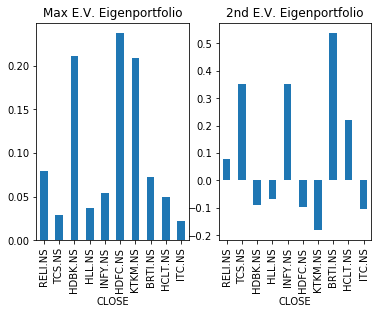

In [44]:
import numpy as np

covariance_matrix = in_sample.cov()

D, S = np.linalg.eigh(covariance_matrix)

eigenportfolio_1 = S[:,-1] / np.sum(S[:,-1]) # Normalize to sum to 1

eigenportfolio_2 = S[:,-2] / np.sum(S[:,-2]) # Normalize to sum to 1


# Setup Portfolios
eigenportfolio = pd.DataFrame(data= eigenportfolio_1, columns = ['Investment Weight'], index = tickers)
eigenportfolio2 = pd.DataFrame(data= eigenportfolio_2, columns = ['Investment Weight'], index = tickers)

# Plot
%matplotlib inline
import matplotlib.pyplot as plt
f = plt.figure()

ax = plt.subplot(121)
eigenportfolio.plot(kind='bar', ax=ax, legend=False)
plt.title("Max E.V. Eigenportfolio")
ax = plt.subplot(122)
eigenportfolio2.plot(kind='bar', ax=ax, legend=False)
plt.title("2nd E.V. Eigenportfolio")

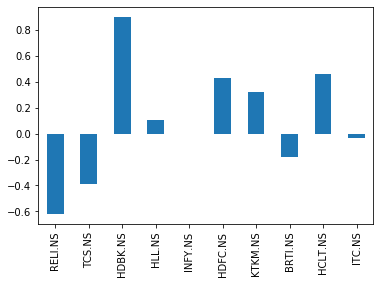

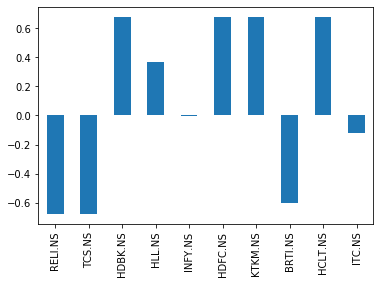

In [32]:
portwts.plot(kind='bar', legend=False)

newwts = portwts.clip(lower=-0.2,upper=0.2,axis=0)
newwts = newwts/newwts.sum(axis=0)
newwts.plot(kind='bar', legend=False)

In [215]:
import matplotlib.pyplot as plt
%matplotlib inline

def get_cumulative_returns_over_time(sample, weights):
    return (((1+sample).cumprod(axis=0))-1).dot(weights)

in_sample_ind = np.arange(0, (returns.shape[0]-training_period+1))
out_sample_ind = np.arange((returns.shape[0]-training_period+1), returns.shape[0])

cumulative_returns = get_cumulative_returns_over_time(returns, eigenportfolio).values

f = plt.figure(figsize=(10,4))

ax = plt.subplot(121)
ax.plot(cumulative_returns[in_sample_ind], 'black')
ax.plot(out_sample_ind,cumulative_returns[out_sample_ind], 'r')
plt.title("Eigenportfolio")

ax = plt.subplot(122)
plt.plot((((1+indexreturns).cumprod(axis=0))-1))
plt.title("Nifty50")

ValueError: matrices are not aligned

In [190]:
# eigenportfolio.sort_index()
returns.sort_index(axis=1)

CLOSE,COAL.NS,HDBK.NS,HDFC.NS,ICBK.NS,INFY.NS,ITC.NS,ONGC.NS,RELI.NS,SBI.NS,TCS.NS
Date,,,,,,,,,,
2015-01-06,-0.000789,-0.015567,-0.049309,-0.042418,-0.020893,-0.025710,-0.061528,-0.049169,-0.041087,-0.036866
2015-01-07,-0.013818,0.002919,-0.000319,-0.027039,0.004785,-0.016944,0.020648,0.030631,0.000834,-0.011812
2015-01-08,0.012677,0.021005,0.022320,0.027199,0.005042,0.022323,0.005611,-0.017483,0.015659,0.010795
2015-01-09,-0.011596,0.011193,-0.010827,-0.016117,0.051179,-0.008154,0.029662,0.021945,-0.005412,0.028030
2015-01-12,-0.045861,-0.008815,0.017252,0.013749,0.020005,-0.002647,-0.009983,-0.010447,0.012863,-0.001035
2015-01-13,0.009361,-0.003826,-0.005358,-0.016304,-0.012784,0.008801,-0.019879,-0.008798,-0.006513,-0.004702
2015-01-14,0.005537,0.000571,-0.001959,-0.011734,0.019029,-0.034898,0.012640,-0.009467,-0.001311,0.009628
2015-01-15,0.014455,0.030345,0.065215,0.047343,0.002631,0.022672,-0.001306,0.031063,0.051198,0.006800
2015-01-16,0.028769,0.008257,0.003350,0.002834,-0.007473,0.010243,0.008429,0.005214,-0.015142,-0.002737


In [61]:
covariance_matrix = in_sample.cov()

D, S = np.linalg.eigh(covariance_matrix)

in_sample_ind = np.arange(0, (returns.shape[0]-training_period+1))
out_sample_ind = np.arange((returns.shape[0]-training_period+1), returns.shape[0])

SharpeList = []
    
for i in range(len(S)):
    eigenportfolio_1 = S[:,-i] / np.sum(S[:,-i]) # Normalize to sum to 1
    eigenportfolio = pd.DataFrame(data= eigenportfolio_1, columns = ['Investment Weight'], index = tickers)

    cumulative_returns = get_cumulative_returns_over_time(returns, eigenportfolio).values
    SharpeList.append(cumulative_returns[-1][0]/np.std(cumulative_returns))
    
print(np.argmax(SharpeList))

[1.6787639102874272, 2.243213455244665, 2.3204141674006085, -2.308655185355843, 2.4620741653552476, 2.468403493502742, 1.7397023528875737, 0.2933620663885827, -0.5627062724594541, 2.8389051091077055]
9


In [50]:
len(S)

10

In [46]:
    import numpy as np
    
    covariance_matrix = in_sample.cov().values
    inv_cov_mat = np.linalg.pinv(covariance_matrix) # Use pseudo-inverse incase matrix is singular / ill-conditioned
    
    # Construct minimum variance weights
    ones = np.ones(len(inv_cov_mat))
    inv_dot_ones = np.dot(inv_cov_mat, ones)
    min_var_weights = inv_dot_ones/ np.dot( inv_dot_ones , ones)
    
    min_var_portfolio = pd.DataFrame(data= min_var_weights, columns = ['Investment Weight'], index = tickers)
    min_var_portfolio

,Investment Weight
CLOSE,
RELI.NS,0.080581
TCS.NS,0.035185
HDBK.NS,0.063321
HLL.NS,0.378907
INFY.NS,0.105514
HDFC.NS,-0.036194
KTKM.NS,-0.030257
BRTI.NS,0.058191
HCLT.NS,0.206516


         Investment Weight
CLOSE                     
RELI.NS           0.080581
TCS.NS            0.035185
HDBK.NS           0.063321
HLL.NS            0.378907
INFY.NS           0.105514
HDFC.NS          -0.036194
KTKM.NS          -0.030257
BRTI.NS           0.058191
HCLT.NS           0.206516
ITC.NS            0.138236


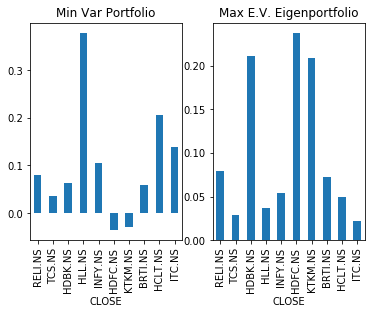

In [47]:
# Largest eigenvalue eigenportfolio
D, S = np.linalg.eigh(covariance_matrix)
eigenportfolio_1 = S[:,-1] / np.sum(S[:,-1]) # Normalize to sum to 1
eigenportfolio_largest = pd.DataFrame(data= eigenportfolio_1, columns = ['Investment Weight'], index = tickers)

# Plot
%matplotlib inline
import matplotlib.pyplot as plt
f = plt.figure()
ax = plt.subplot(121)
min_var_portfolio.plot(kind='bar', ax=ax, legend=False)
plt.title("Min Var Portfolio")
ax = plt.subplot(122)
eigenportfolio_largest.plot(kind='bar', ax=ax, legend=False)
plt.title("Max E.V. Eigenportfolio")
print(min_var_portfolio)

Text(0.5, 1.0, 'Eigenportfolio')

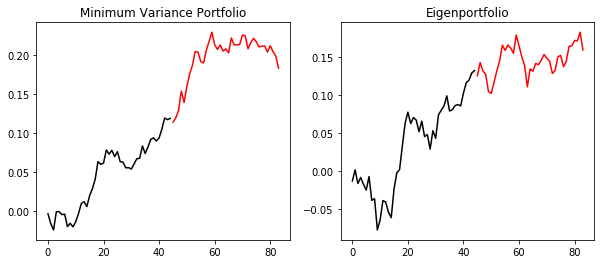

In [48]:
def get_cumulative_returns_over_time(sample, weights):
    return (((1+sample).cumprod(axis=0))-1).dot(weights)

in_sample_ind = np.arange(0, (returns.shape[0]-training_period+1))
out_sample_ind = np.arange((returns.shape[0]-training_period+1), returns.shape[0])

cumulative_returns = get_cumulative_returns_over_time(returns, min_var_portfolio).values
cumulative_returns_largest = get_cumulative_returns_over_time(returns, eigenportfolio_largest).values


f = plt.figure(figsize=(10,4))

ax = plt.subplot(121)
ax.plot(cumulative_returns[in_sample_ind], 'black')
ax.plot(out_sample_ind,cumulative_returns[out_sample_ind], 'r')
plt.title("Minimum Variance Portfolio")

ax = plt.subplot(122)
ax.plot(cumulative_returns_largest[in_sample_ind], 'black')
ax.plot(out_sample_ind,cumulative_returns_largest[out_sample_ind], 'r')
plt.title("Eigenportfolio")

